# Uplift Random Forest

In [1]:
import sys
sys.path.append("/home/mori/Documents/h2o/env/h2o-env/lib/python3.7/site-packages")
sys.path.append("/home/mori/Documents/h2o/code/h2o-3/h2o-py/")

In [2]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split

import h2o
from causalml.metrics import plot_gain, plot_qini, plot_lift
from causalml.metrics import auuc_score
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [3]:
# Data generation
df, x_names = make_uplift_classification(n_samples=10000)

# Rename features for easy interpretation of visualization
x_names_new = ['feature_%s'%(i) for i in range(len(x_names))]
rename_dict = {x_names[i]:x_names_new[i] for i in range(len(x_names))}
df = df.rename(columns=rename_dict)
x_names = x_names_new

print(df.head())

df = df[df['treatment_group_key'].isin(['control','treatment1'])]

df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

  treatment_group_key  feature_0  feature_1  feature_2  feature_3  feature_4  \
0             control   0.909486   0.828268  -0.016712  -0.872802   0.380530   
1          treatment2  -0.028409  -1.427630   1.813986   0.705597   1.148271   
2             control  -0.132473  -1.772580   0.695160  -0.985407  -0.943285   
3          treatment2  -1.311725  -0.713705  -1.778944   0.155594  -0.580109   
4          treatment3  -1.381492  -0.529531   2.140560   0.306833   0.272251   

   feature_5  feature_6  feature_7  feature_8  ...  feature_11  feature_12  \
0   0.273171  -0.020009   0.194151   1.387024  ...   -1.957461   -0.775339   
1  -1.996377  -0.801034  -1.699141  -0.139903  ...   -0.622281   -0.962357   
2   1.040515  -1.382704   0.795706  -0.517023  ...   -0.747040   -0.571946   
3   0.939822   0.425115  -1.223984   0.543634  ...   -0.544115    0.482647   
4  -1.353378   1.837827  -0.536166   0.273723  ...   -0.633821   -1.095470   

   feature_13  feature_14  feature_15  feature_16 

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.5012,10000
treatment1,0.5160,10000
All,0.5086,20000


In [4]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
df_train.shape, df_test.shape

((16000, 22), (4000, 22))

In [5]:
ntree = 100
max_depth = 5
control_name = "control"
treatment_column = "treatment_group_key"
response_column = "conversion"

## CausalML

In [6]:
# Train CausalML uplift tree
causalml_uplift_model = UpliftRandomForestClassifier(
        n_estimators=ntree,
        max_depth=max_depth,
        evaluationFunction='KL',
        control_name=control_name,
        min_samples_leaf=10,
        min_samples_treatment=10,
        normalization=False,
        random_state=42)

causalml_uplift_model.fit(df_train[x_names].values,
                 treatment=df_train[treatment_column].values,
                 y=df_train[response_column].values)

In [7]:
#df_test = df_train
causalml_preds = causalml_uplift_model.predict(df_test.values)

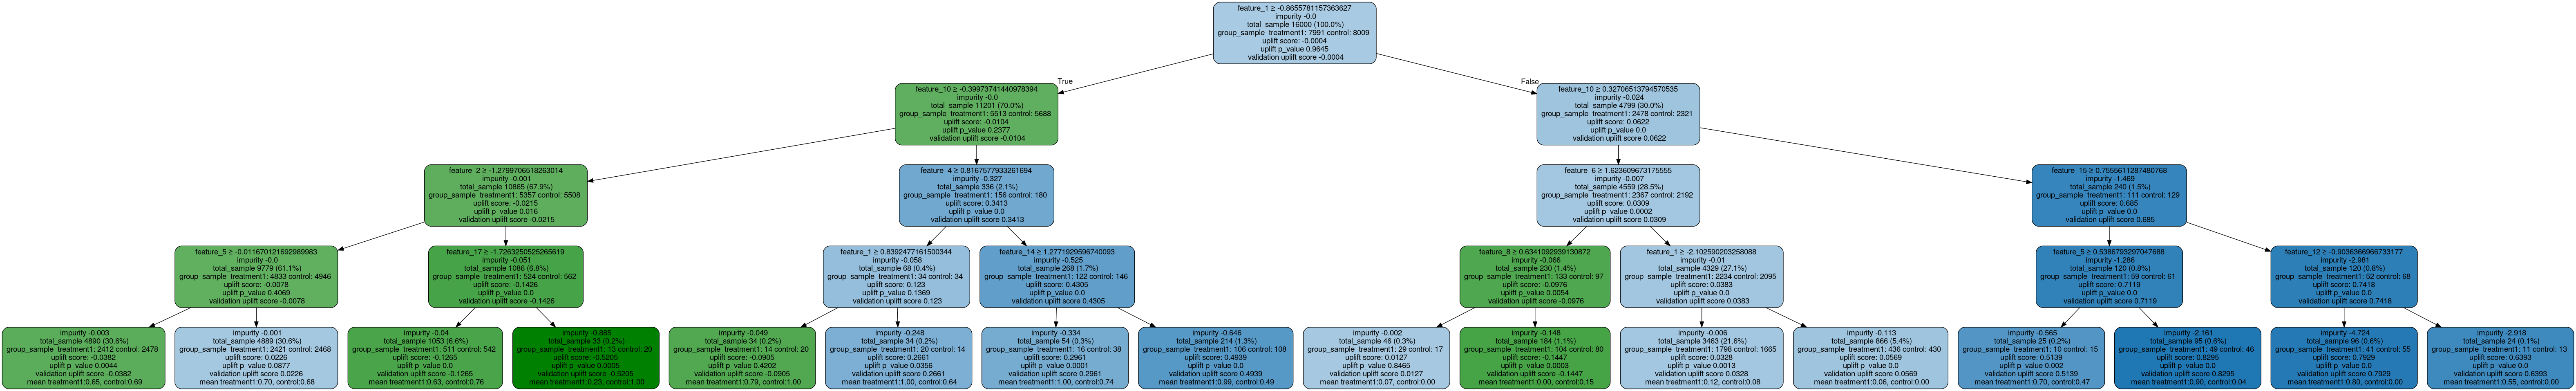

In [8]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[0].fitted_uplift_tree, x_names)
Image(graph.create_png())

In [9]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[1].fitted_uplift_tree, x_names)
img = Image(graph.create_png())

In [10]:
#for i in range(ntree):
#    graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[i].fitted_uplift_tree, x_names)
#    with open("/home/mori/Documents/h2o/code/test/uplift/causal_tree/causal_tee_"+str(i)+".png", "wb") as fout:
#        fout.write(graph.create_png())

## H2O-3

In [11]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 min 29 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.0.99999
H2O_cluster_version_age:,4 days
H2O_cluster_name:,mori
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.894 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [12]:
train_h2o = h2o.H2OFrame(df_train)
train_h2o[treatment_column] = train_h2o[treatment_column].asfactor()
train_h2o[response_column] = train_h2o[response_column].asfactor()
h2o_uplift_model = H2OUpliftRandomForestEstimator(
            ntrees=ntree,
            max_depth=max_depth-1,
            uplift_column=treatment_column,
            uplift_metric="KL",
            distribution="bernoulli",
            gainslift_bins=10,
            min_rows=10,
            nbins=1000,
            seed=42,
            sample_rate=0.99,
            auuc_type="gain"
)
h2o_uplift_model.train(y=response_column, x=x_names, training_frame=train_h2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%
upliftdrf Model Build progress: |█████████████████████████████████████████| 100%


In [13]:
# Print H2O tree using Graphviz
def plot_trees(model, tree_index=None, dot_path='/home/mori/Documents/h2o/code/test/quantile_constraints/tree.dot'):
    try:
        import graphviz
        mojo_path = model.download_mojo()
        mojo_dot = h2o.print_mojo(mojo_path, format='dot')

        with open(dot_path, 'a') as the_file:
            the_file.write(mojo_dot)
        
        return graphviz.Source(mojo_dot)
    except:
        print("Error occured, propably graphviz is not installed.")

In [14]:
plot_trees(h2o_uplift_model)

Error occured, propably graphviz is not installed.


In [15]:
model = h2o_uplift_model
mojo_path = model.download_mojo()
# print mojo fails
#mojo_dot = h2o.print_mojo(mojo_path, format='dot')

In [16]:
from h2o.tree import H2OTree, H2ONode

In [17]:
tree = H2OTree(h2o_uplift_model, 4, 1)
print(tree.tree_decision_path)

If ( feature_10 >= -1.9935678 or feature_10 is NaN ) {

	If ( feature_9 >= -3.053643 or feature_9 is NaN ) {
	
		If ( feature_1 >= 4.2445655 ) {
		
			Predicted value: 0.9285714
			
		} else {
		
			If ( feature_1 >= -2.632146 or feature_1 is NaN ) {
			
				Predicted value: 0.5104045
				
			} else {
			
				Predicted value: 0.028368793
				
			}
		}
	} else {
	
		Predicted value: 0.5
		
	}
} else {

	Predicted value: 0.45
	
}


In [18]:
tree = H2OTree(h2o_uplift_model, 0, 0)
print(tree.tree_decision_path)

If ( feature_14 >= 3.7737708 ) {

	Predicted value: 0.5
	
} else {

	If ( feature_10 >= -1.998665 or feature_10 is NaN ) {
	
		If ( feature_15 >= -1.1028004 or feature_15 is NaN ) {
		
			If ( feature_3 >= 3.095637 ) {
			
				Predicted value: 0.875
				
			} else {
			
				Predicted value: 0.5108835
				
			}
		} else {
		
			Predicted value: 0.54545456
			
		}
	} else {
	
		Predicted value: 0.9714286
		
	}
}


In [19]:
test_h2o = h2o.H2OFrame(df_test)
preds_h2o = h2o_uplift_model.predict(test_h2o)
preds_h2o

Parse progress: |█████████████████████████████████████████████████████████| 100%
upliftdrf prediction progress: |██████████████████████████████████████████| 100%


uplift_predict,p_y1_ct1,p_y1_ct0
0.00979631,0.514767,0.504971
0.00979631,0.514767,0.504971
0.023937,0.436558,0.412621
0.00979631,0.514767,0.504971
0.00979631,0.514767,0.504971
0.00979631,0.514767,0.504971
0.00979631,0.514767,0.504971
0.00979631,0.514767,0.504971
0.00979631,0.514767,0.504971
0.00348,0.510556,0.507076


In [20]:
preds_comp = preds_h2o["uplift_predict"]
preds_comp.names = ["h2o"]
preds_comp["causal"] = h2o.H2OFrame(causalml_preds)
preds_comp["diff"] = abs(preds_comp["h2o"] - preds_comp["causal"])
preds_comp[treatment_column] = h2o.H2OFrame(df_test[treatment_column].values)
preds_comp[response_column] = h2o.H2OFrame(df_test[response_column].values)
preds_comp.summary()
    
min_diff = preds_comp["diff"].min()
max_diff = preds_comp["diff"].max()
mean_diff = preds_comp["diff"].mean(return_frame=False)[0]
print("min: %f max: %f mean: %f" % (min_diff, max_diff, mean_diff))

results = preds_comp.as_data_frame()
mapping = {'treatment1': 1, 'control': 0}
results = results.replace({treatment_column: mapping})
results = results[["h2o", "causal", response_column, treatment_column]]

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


,h2o,causal,diff,treatment_group_key,conversion
type,real,real,real,enum,int
mins,-0.14700335323810582,-0.04022335999999993,3.6041259269259385e-05,,0.0
mean,0.011635794949207941,0.20100548944250002,0.1919427151905793,,0.50575
maxs,0.27936123803257945,0.8279019700000004,0.9226793362446214,,1.0
sigma,0.022600246492401724,0.22947181637520137,0.2282525336360506,,0.5000294439942665
zeros,0,0,0,,1977
missing,0,0,0,0,0
0,0.009796311259269719,0.019752020000000203,0.009955708740730485,control,1.0
1,0.009796311259269719,0.06528316000000012,0.0554868487407304,control,1.0
2,0.023936999347060894,0.30100112999999995,0.27706413065293906,treatment1,0.0


min: 0.000036 max: 0.922679 mean: 0.191943


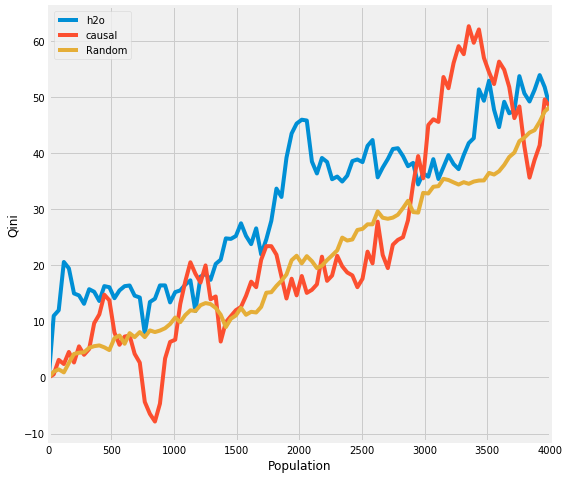

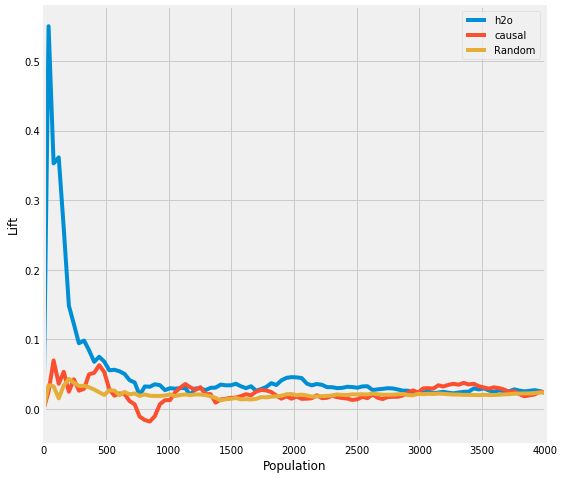

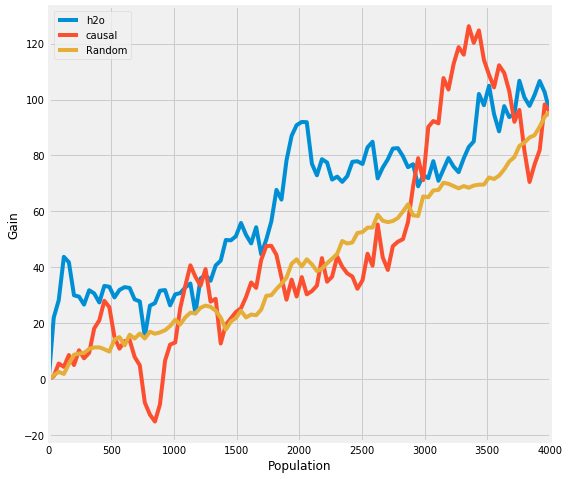

In [21]:
plot_qini(results, outcome_col=response_column, treatment_col=treatment_column)
plot_lift(results, outcome_col=response_column, treatment_col=treatment_column)
plot_gain(results, outcome_col=response_column, treatment_col=treatment_column)

In [22]:
auuc = auuc_score(results, outcome_col=response_column, treatment_col=treatment_column, normalize=False)
print("H2O AUUC:")
print(auuc["h2o"])
print("CauslML AUUC:")
print(auuc["causal"])
print("Random AUUC:")
print(auuc["Random"])

H2O AUUC:
61.767038960636036
CauslML AUUC:
46.282850644146535
Random AUUC:
41.08259701725644


In [23]:
perf_h2o = h2o_uplift_model.model_performance(test_h2o)
auuc_h2o = perf_h2o.auuc()
print("H2O training metrics AUUC Gain: "+str(auuc_h2o))

H2O training metrics AUUC Gain: 206.35037581285954


In [35]:
print(len(perf_h2o.plot_auuc(metric="qini", plot=False)[0]))
print(len(perf_h2o.plot_auuc(metric="qini", plot=False)[1]))

80
80


[2, 3, 19, 19, 21, 21, 22, 23, 25, 45, 45, 46, 51, 51, 52, 54, 54, 56, 56, 59, 59, 60, 65, 66, 67, 116, 116, 121, 122, 124, 124, 129, 132, 132, 197, 197, 198, 199, 206, 206, 207, 295, 295, 297, 318, 318, 3936, 3936, 3941, 3941, 3945, 3945, 3946, 3947, 3951, 3953, 3953, 3954, 3957, 3957, 3960, 3960, 3961, 3969, 3969, 3974, 3974, 3977, 3977, 3979, 3979, 3980, 3981, 3982, 3986, 3986, 3992, 3992, 3993, 4000]
[0.0, 0.0, 7.2, 9.0, 7.5, 9.0, 10.0, 11.0, 9.428571428571429, 17.772727272727273, 23.0, 23.0, 23.076923076923077, 25.0, 25.0, 24.071428571428573, 25.0, 26.0, 26.0, 27.0, 27.0, 27.0, 25.176470588235293, 27.0, 27.0, 34.67213114754098, 50.0, 50.0, 50.0, 48.24242424242424, 50.0, 50.0, 50.0, 50.0, 51.0, 51.0, 51.0, 51.0, 49.076190476190476, 51.0, 51.0, 49.13333333333333, 53.0, 55.0, 55.0, 55.0, 93.31140801644403, 1029.0, 1028.977937403797, 1030.0, 1028.9779600205022, 1030.0, 1031.0, 1031.0, 1030.9790281329924, 1029.960143076137, 1032.0, 1033.0, 1031.9601837672283, 1034.0, 1034.9795918367347

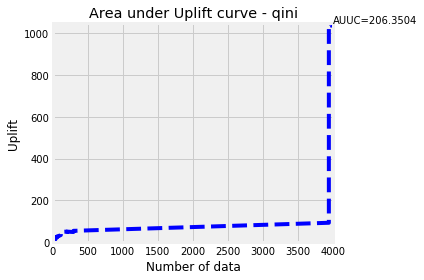

In [29]:
print(perf_h2o.plot_auuc(metric="qini", plot=False)[0])
print(perf_h2o.plot_auuc(metric="qini", plot=False)[1])
perf_h2o.plot_auuc(metric="qini")

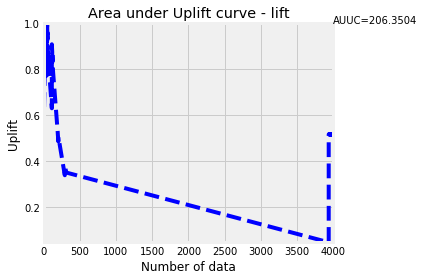

In [25]:
perf_h2o.plot_auuc(metric="lift")

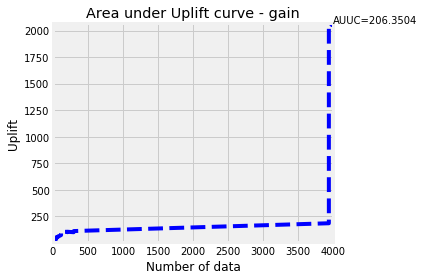

In [26]:
perf_h2o.plot_auuc(metric="gain")